In [34]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/table_setting/table_setting_environments_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/table_setting/table_setting_environments_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
scenes_dataset_yaml_test = dataset_utils.ScenesDataset(DATA_DIR_TEST)
params_by_object_class = {}
num_objs_per_env = []
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    num_objs_per_env.append(env["n_objects"])
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
for env_i in range(len(scenes_dataset_yaml_test)):
    env = scenes_dataset_yaml[env_i]
    num_objs_per_env.append(env["n_objects"])
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)
    
print("%d objects max, %d objects mean" % (np.max(num_objs_per_env), np.mean(num_objs_per_env)))

fork : 
(150, 5)
means:  [ 0.4930537   0.50883185 -1.31272411  0.02        0.14      ]
vars:  [2.10048198e-01 2.57187840e-01 4.21093918e+00 1.38777878e-17
 3.05311332e-16]
plate : 
(148, 4)
means:  [ 0.49676577  0.49932132 -1.23490162  0.2       ]
vars:  [2.06209868e-01 2.41114345e-01 3.15323595e+00 4.99600361e-16]
spoon : 
(66, 5)
means:  [ 0.51469865  0.49093687 -1.47311712  0.02        0.12      ]
vars:  [2.16008655e-01 2.27192516e-01 4.11022270e+00 1.04083409e-17
 9.71445147e-17]
knife : 
(126, 5)
means:  [ 0.51329982  0.50148457 -1.19043825  0.015       0.15      ]
vars:  [2.21778558e-01 2.45836910e-01 4.46503722e+00 3.81639165e-17
 0.00000000e+00]
cup : 
(144, 4)
means:  [ 0.50814931  0.49291551 -1.886693    0.05      ]
vars:  [1.30286413e-01 1.43177694e-01 3.24560179e+00 1.24900090e-16]
28 objects max, 12 objects mean


38


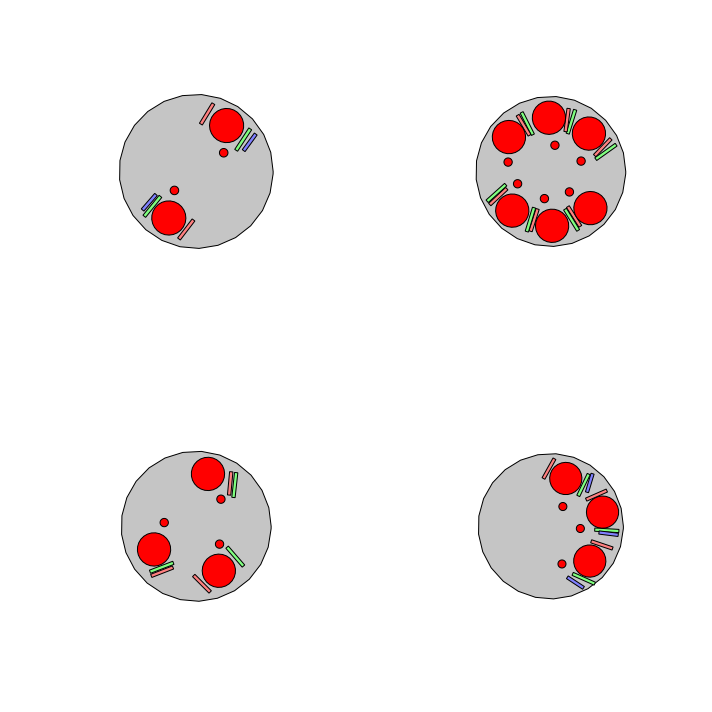

In [36]:
print len(scenes_dataset_yaml)

plt.figure().set_size_inches(10, 10)
side_width = 2
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scenes_dataset_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "table_setting", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("")
        plt.tight_layout()

In [53]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=30,
    memorize_params=True,
    base_environment_type="table_setting")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=30,
    memorize_params=True,
    base_environment_type="table_setting")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

print scenes_dataset.get_num_classes()
print scenes_dataset.class_id_to_name
print scenes_dataset.get_num_params_by_class()

Train batch size:  38
Test batch size:  12
5
['plate', 'fork', 'cup', 'knife', 'spoon']
[3, 3, 3, 3, 3]


In [58]:
pyro.enable_validation(True)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().save("table_setting_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.001, 'betas': [0.9, 0.99], 'weight_decay': 1E-4},
      "step_size": 300,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

rotation_origin = torch.tensor([0.5, 0.5])
def make_rotmat(r):
    return torch.tensor([[np.cos(r), -np.sin(r)],
                         [np.sin(r), np.cos(r)]])

snapshots = {}
for i in range(1000):
    start_time = time.time()
    
    # Non-destructively mutate dataset by randomly rotating it
    r_curr = np.random.uniform(0, 2*np.pi)
    rotmat = make_rotmat(r_curr)
    for params in data.params_by_class:
        params[:, :, 2] += r_curr
        params[:, :, 2] = torch.fmod(params[:, :, 2], np.pi*2.)
        params[:, :, :2] = torch.matmul(rotmat, (params[:, :, 0:2] - rotation_origin).unsqueeze(-1)).squeeze(-1) + rotation_origin[0]
    for params in data_test.params_by_class:
        params[:, :, 2] += r_curr
        params[:, :, 2] = torch.fmod(params[:, :, 2], np.pi*2.)
        params[:, :, :2] = torch.matmul(rotmat, (params[:, :, 0:2] - rotation_origin).unsqueeze(-1)).squeeze(-1) + rotation_origin[0]
    
    loss = svi.step(data) / data.batch_size
    losses.append(loss)

    loss_test = svi.evaluate_loss(data_test) / data_test.batch_size
    losses_test.append(loss_test)

    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

    if loss_test < best_test_loss:
        pyro.get_param_store().save("best_on_test_save.pyro")
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if loss_test > 100000 or (i > 300 and cycles_since_improvement > 300):
            print("Terminating early due to rising test loss")
            break

print "Done"

Iter: 0, Loss: 123.981539, Loss_test: 127.957509, Best test loss: inf, Time per step: 3.878930
Iter: 1, Loss: 120.499649, Loss_test: 126.852722, Best test loss: 127.957509, Time per step: 4.195449
Iter: 2, Loss: 118.919157, Loss_test: 129.493907, Best test loss: 126.852722, Time per step: 3.837721
Iter: 3, Loss: 121.292473, Loss_test: 130.860728, Best test loss: 126.852722, Time per step: 3.856357
Iter: 4, Loss: 114.864062, Loss_test: 126.290629, Best test loss: 126.852722, Time per step: 3.996700
Iter: 5, Loss: 119.327445, Loss_test: 131.064799, Best test loss: 126.290629, Time per step: 3.833723
Iter: 6, Loss: 113.901179, Loss_test: 121.241170, Best test loss: 126.290629, Time per step: 3.941245
Iter: 7, Loss: 118.023874, Loss_test: 128.946381, Best test loss: 121.241170, Time per step: 3.867829
Iter: 8, Loss: 109.534305, Loss_test: 115.142131, Best test loss: 121.241170, Time per step: 3.642222
Iter: 9, Loss: 108.919635, Loss_test: 113.475474, Best test loss: 115.142131, Time per st

Iter: 82, Loss: 88.767063, Loss_test: 101.066477, Best test loss: 95.723043, Time per step: 3.938661
Iter: 83, Loss: 88.013754, Loss_test: 94.257111, Best test loss: 95.723043, Time per step: 3.904954
Iter: 84, Loss: 89.694932, Loss_test: 96.692963, Best test loss: 94.257111, Time per step: 3.899348
Iter: 85, Loss: 88.053370, Loss_test: 94.573120, Best test loss: 94.257111, Time per step: 3.898087
Iter: 86, Loss: 90.428159, Loss_test: 104.593740, Best test loss: 94.257111, Time per step: 4.008970
Iter: 87, Loss: 90.238490, Loss_test: 98.404185, Best test loss: 94.257111, Time per step: 3.881078
Iter: 88, Loss: 86.767123, Loss_test: 96.332428, Best test loss: 94.257111, Time per step: 3.803524
Iter: 89, Loss: 88.932049, Loss_test: 104.152588, Best test loss: 94.257111, Time per step: 3.822400
Iter: 90, Loss: 87.526467, Loss_test: 93.876373, Best test loss: 94.257111, Time per step: 3.790910
Iter: 91, Loss: 87.072306, Loss_test: 95.917521, Best test loss: 93.876373, Time per step: 4.0633

Iter: 164, Loss: 83.881411, Loss_test: 97.032664, Best test loss: 92.231730, Time per step: 3.943261
Iter: 165, Loss: 84.963860, Loss_test: 99.111562, Best test loss: 92.231730, Time per step: 3.968142
Iter: 166, Loss: 84.484200, Loss_test: 93.685059, Best test loss: 92.231730, Time per step: 3.852934
Iter: 167, Loss: 85.538355, Loss_test: 98.479696, Best test loss: 92.231730, Time per step: 3.936710
Iter: 168, Loss: 84.814629, Loss_test: 93.147888, Best test loss: 92.231730, Time per step: 3.881688
Iter: 169, Loss: 83.656494, Loss_test: 94.832977, Best test loss: 92.231730, Time per step: 3.812596
Iter: 170, Loss: 84.406070, Loss_test: 100.334951, Best test loss: 92.231730, Time per step: 3.832493
Iter: 171, Loss: 84.810834, Loss_test: 99.464762, Best test loss: 92.231730, Time per step: 3.740152
Iter: 172, Loss: 86.451166, Loss_test: 97.353312, Best test loss: 92.231730, Time per step: 4.011606
Iter: 173, Loss: 87.098024, Loss_test: 102.496775, Best test loss: 92.231730, Time per ste

KeyboardInterrupt: 

In [59]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().load("best_on_test_save.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

('Loaded model evaluated on all of test: ', 100.51268513997395)


Text(0.5,1,'Loses: final [84.893625 train][98.226989 test][92.231730 best test]')

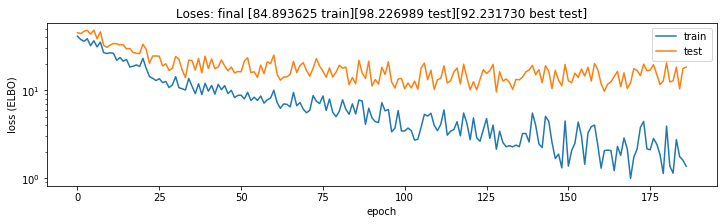

In [60]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test][%f best test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:]), best_test_loss))
#print("Model evaluated on all of test: ",
#      svi.evaluate_loss(data_test) / data_test.batch_size)

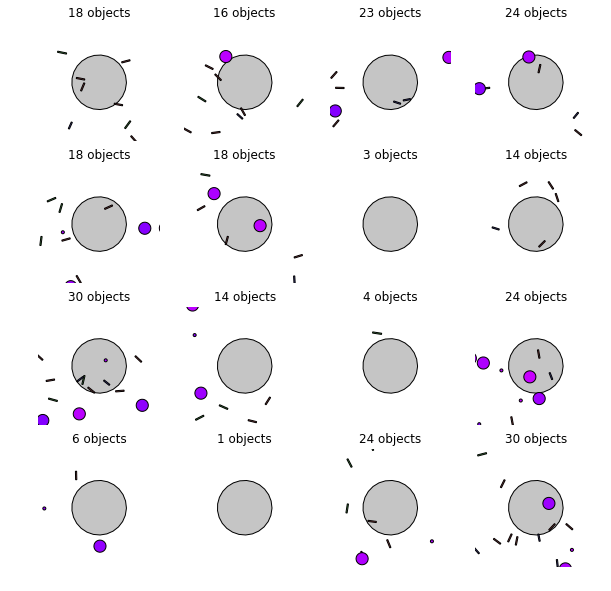

In [61]:
# Convert that data back to a YAML environment, which is easier to
# handle.
import scipy.stats
side_width = 4
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scene_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "table_setting", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("%d objects" % scene["n_objects"])